# **Comparison of Bootstrap Filter vs. PAL Likelihood Approximations**

## Imports


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import binom, truncnorm, gamma
from scipy.special import factorial

# For reproducibility if you like
np.random.seed(1234)


## Define the Data and Global Parameters


In [4]:
# Example data Y (Influenza in Wales or your own data)
Y = np.array([
    [0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],
    [73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],
    [3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],
    [0,1,4,6],[0,1,3,0],[2,1,7,1],[1,1,6,2]
])

h   = 1/7
pho = 2/3
g   = 2/3
R   = 19
T   = 7*R

# For truncated normals
def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


## PAL Code (already given)


In [5]:
###################################
# PAL (Poisson Approx. Likelihood) Code
###################################

def K(k, betas):
    K_mat = np.zeros((4,4))
    K_mat[0, 0], K_mat[0, 1] = np.exp(-betas[k]*h), 1-np.exp(-betas[k]*h)
    K_mat[1, 1], K_mat[1, 2] = np.exp(-h*pho), 1-np.exp(-h*pho)
    K_mat[2, 2], K_mat[2, 3], K_mat[3, 3] = np.exp(-h*g), 1-np.exp(-h*g), 1
    return K_mat

def calcul(Y_val, G, P, Q):
    # Slightly renamed Y->Y_val to avoid confusion with global Y
    Q_new = Q
    for s in np.argwhere(Q == 0):
        if Y_val[s[0]][s[1]]==0 or G[s[0]][s[1]]==0 or P[s[0]][s[1]]==0:
             Q_new[s[0]][s[1]] = 1
    M = np.multiply(Y_val, np.multiply(G, np.divide(P, Q)))
    for s in np.argwhere(Q == 0):
        M[s[0]][s[1]] = 0
    return M

def log_factorial(Y_val):
    # A simplified approach for factorial in a 4x4 matrix
    M = np.zeros((4,4))
    # Hard-coded example for [1,2]; adapt for general usage if needed
    val = Y_val[1,2]
    if val>1:
        M[1][2] = np.sum(np.log(np.arange(1, val+1)))
    return M

# Initial states
X1 = np.array([948, 0, 1, 0])
X2 = np.array([1689, 0, 1, 0])
X3 = np.array([3466, 0, 1, 0])
X4 = np.array([1894, 0, 1, 0])

def PAL(y, theta, R=19):
    """
    At each time r in [0..R-1],
    returns partial log-likelihood for each of the 4 compartments.
    """
    # X shape = (4,4)
    X = np.array([X1, X2, X3, X4]) 
    B = theta[:16].reshape(4,4)
    L = np.zeros((R, 4))

    for r_i in range(R):
        # G shape = (7,4,4,4)
        G = np.zeros((7, 4, 4, 4))
        for i in range(6):
            I = X[:, 2]   
            betas = 1/8000 * np.dot(B, I)
            for k in range(4):
                G[i][k] = np.multiply(np.outer(np.ones(4), X[k]), K(k, betas))
                X[k] = np.transpose(np.dot(np.ones(4), G[i][k].T))  # row-sum

        # final step i=6
        I = X[:, 2]   
        betas = 1/8000 * np.dot(B, I)
        for k in range(4):
            G[6][k] = np.multiply(np.outer(np.ones(4), X[k]), K(k, betas))
            M = np.zeros((4,4))
            Q = np.zeros((4,4))
            Q[1][2] = theta[k+16]  # parameter for data link
            for i in range(7):
                M += np.multiply(G[i][k], Q)
            Y_bar = np.zeros((4,4))
            Y_bar[1][2] = y[r_i][k]

            G_bar = np.multiply(np.outer(np.ones(4), np.ones(4))-Q, G[i][k]) \
                    + calcul(Y_bar, G[6][k], Q, M)

            X[k] = np.transpose(np.dot(np.ones(4), G_bar.T))  # row-sum

            # log-likelihood contribution
            # 1) - sum(M)
            # 2) + sum(Y_bar * log(M))
            # 3) - sum(log_factorial(Y_bar))
            sumM = np.dot(np.ones(4), np.dot(M, np.ones(4)))
            logM = 0.0
            if np.any(M>0):
                logM = np.dot(np.ones(4), 
                              np.dot(np.multiply(Y_bar, np.log(M+1e-12)), np.ones(4)))
            lf = np.dot(np.ones(4), np.dot(log_factorial(Y_bar), np.ones(4)))
            L[r_i][k] = -sumM + logM - lf

    return L

def log_PAL(y, theta, R=19):
    """
    Cumulative sum across time for each of the 4 compartments.
    """
    L_times = PAL(y, theta, R=R)  # shape (R,4)
    for r_i in range(1, R):
        L_times[r_i] = np.sum(L_times[:r_i, :], axis=0)
    return L_times

def log_prior_pal(theta):
    """
    Example prior: product of Gamma for first 16, truncated norm for last 4.
    """
    prior_val = 1.0
    for i in range(16):
        prior_val *= gamma.pdf(theta[i], a=5, scale=1)  # shape=1 => rate=1
    for i in range(4):
        prior_val *= truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5)
    if prior_val == 0:
        return -1e5
    return np.log(prior_val)

def logL_pal(y, theta, R=19):
    """
    Returns 4D log-likelihood + prior, then we often sum it.
    """
    L_cumul = log_PAL(y, theta, R=R)  # shape (R,4)
    # final row = sum up to time R
    L_vec = L_cumul[-1, :]
    return L_vec + log_prior_pal(theta)

###################################
#  Single-scalar PAL log-likelihood
###################################
def PAL_loglike(Y, theta, R=19):
    """
    Summation of the 4-compartment log-likelihood + prior
    => single scalar
    """
    L_vec = logL_pal(Y, theta, R)
    return np.sum(L_vec)


## Bootstrap Filter (PMMH) Code


In [6]:
###################################
# Bootstrap Filter & PMMH-related
###################################

def ESS(W):
    return 1.0 / np.sum(W**2)

def mutation(theta, X):
    X_new = X.copy()
    S, E, I, R_ = X_new[:, 0], X_new[:, 1], X_new[:, 2], X_new[:, 3]
    M = theta[:16].reshape(4,4)
    betas = 1/8000 * np.dot(M, I)
    B = np.random.binomial(S.astype(int), 1 - np.exp(-h * betas))
    C = np.random.binomial(E.astype(int), 1 - np.exp(-h * pho))
    D = np.random.binomial(I.astype(int), 1 - np.exp(-h * g))
    S_new = S - B
    E_new = E + B - C
    I_new = I + C - D
    R_new = R_ + D
    X_new[:, 0], X_new[:, 1], X_new[:, 2], X_new[:, 3] = S_new, E_new, I_new, R_new
    return X_new

def log_f(y, theta, X):
    """
    One-step likelihood contribution for 4 compartments
    over a 7-day chunk, then binomial pmf for y vs sum(C).
    """
    # We'll replicate your approach:
    C = np.zeros((7,4))
    X_loc = X.copy()
    for i in range(7):
        X_loc = mutation(theta, X_loc)
        C[i] = np.random.binomial(X_loc[:, 1].astype(int), 1 - np.exp(-h*pho))
    # pmf + 1.5 offset => to avoid zero
    # shape is (4,) because binom.pmf is done per compartment
    try:
        val = binom.pmf(y, np.sum(C, axis=0).astype(int), theta[16:])
        return np.log(val + 1.5)
    except:
        return np.array([-1e5]*4)  # fallback if something is out-of-bounds

# Initial states used by BFS
X1_bf = np.array([948, 0, 1, 0])
X2_bf = np.array([1689, 0, 1, 0])
X3_bf = np.array([3466, 0, 1, 0])
X4_bf = np.array([1894, 0, 1, 0])

def BootstrapFilter(y, theta, ESS_min, N, R=19):
    """
    Returns all states across time for the N particles
    => shape (R+1, N, 4, 4).
    """
    # X shape: (N, 4, 4)
    X = np.array([[X1_bf, X2_bf, X3_bf, X4_bf] for _ in range(N)])
    w_init = np.zeros((N, 4))  # shape (N,4)
    X_all = np.array([X for _ in range(R+1)])  # shape (R+1, N, 4, 4)

    # Step 0: initial weights
    for n in range(N):
        w_init[n] = log_f(y[0], theta, X[n])
    W_init = np.zeros((N, 4))
    for n in range(N):
        denom = np.sum(w_init, axis=0)
        # avoid divide-by-zero
        denom[denom==0] = 1e-12
        W_init[n] = w_init[n] / denom

    W = W_init.copy()
    w = w_init.copy()
    X_all[1] = X.copy()

    for r_i in range(R):
        w_hats = np.zeros((N,4))
        for k in range(4):
            if ESS(W[:, k]) < ESS_min:
                # Resample
                A = np.random.choice(np.arange(N), size=N, p=W[:, k])
                w_hat = np.zeros(N)
            else:
                A = np.arange(N)
                w_hat = w[:, k]
            # Move particles
            for n in range(N):
                X[n][k] = X[A[n]][k]
            w_hats[:, k] = w_hat

        # Next data chunk y[r_i]
        # Recompute log_f
        for n in range(N):
            # accumulate
            w[n] = w_hats[n] + log_f(y[r_i], theta, X[n])

        # Convert log weights w -> normalized W
        # sum over n is in log space => we do a "log-sum-exp" approach or
        # we do naive exponent. We'll do a naive approach for illustration:
        sum_w = np.sum(w, axis=0)
        sum_w[sum_w==0] = 1e-12
        for n in range(N):
            W[n] = w[n] / sum_w
        X_all[r_i+1] = X.copy()

    return X_all

def log_prior_bf(theta):
    # Similar prior as the PAL side
    val = 1.0
    for i in range(16):
        val *= gamma.pdf(theta[i], a=5, scale=1)
    for i in range(4):
        val *= truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5)
    return np.log(val + 1e-12)

def LogL_bf(y, theta, X_all):
    """
    Summation over R steps. 
    For each step r, we look at the average weight or something akin 
    to what you do in PMMH. But your code does it differently (S etc.).
    
    We'll adapt your snippet: you had 'LogL' in your PMMH code. 
    We'll replicate that logic more directly.
    """
    # In your snippet, 'LogL' was:
    #   for r in range(R):
    #       S = 0
    #       for n in range(len(X[r])):
    #           x = X[r][n]
    #           S = S + np.exp(log_f(y[r], theta, x)) - 1.5
    #   ...
    # We'll do something similar. We'll then add log_prior. 
    # We'll return a 4D vector, then we can sum it.

    R_ = X_all.shape[0] - 1  # Should be 19
    N_ = X_all.shape[1]
    L = np.zeros(4)

    for r_i in range(R_):
        S = np.zeros(4)
        for n in range(N_):
            x = X_all[r_i][n]
            # log_f(...) returns shape (4,)
            fval = log_f(y[r_i], theta, x)
            # exp(fval) ~ pmf + 1.5 => handle it carefully
            # We'll do exactly as your snippet:
            S += (np.exp(fval) - 1.5)
        # Next step in snippet:
        for k in range(4):
            if S[k] <= 0:
                L[k] += -1000
            else:
                L[k] += np.log(S[k]) - N_  # same as snippet had

    return L + log_prior_bf(theta)

def BFS_loglike(Y, theta, Nx=100, R=19, ESS_min=999):
    """
    Single-scalar BFS-based log-likelihood:
    1) Run the bootstrap filter (X_all).
    2) Evaluate LogL_bf -> shape(4,)
    3) Sum compartments into 1 scalar.
    """
    X_all = BootstrapFilter(Y, theta, ESS_min=ESS_min, N=Nx, R=R)
    L_vec = LogL_bf(Y, theta, X_all)
    return np.sum(L_vec)


## Compare BFS_loglike vs. PAL_loglike at single or multiple theta


In [7]:
############################
# Comparison
############################

# Let's pick a single "reasonable" theta:
# For illustration, just do a random draw from the prior
theta_test = np.concatenate((
    np.random.gamma(5, 1, 16),
    get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)
))

Nx = 1000  # number of particles for BFS

loglike_bfs_single = BFS_loglike(Y, theta_test, Nx=Nx, R=19, ESS_min=999)
loglike_pal_single = PAL_loglike(Y, theta_test, R=19)

print("Single-theta comparison:")
print("theta_test =", theta_test)
print("BFS log-likelihood =", loglike_bfs_single)
print("PAL log-likelihood =", loglike_pal_single)
print("Difference (BFS - PAL) =", loglike_bfs_single - loglike_pal_single)



Single-theta comparison:
theta_test = [5.7609631  2.53770995 3.27668482 6.8574817  4.7006569  1.30506709
 7.04387884 1.5205028  5.59848639 5.31944892 4.24244641 3.38820354
 8.13264109 3.72449505 4.282178   7.34846705 0.67849028 0.67878243
 0.24926803 0.903302  ]
BFS log-likelihood = -32821.99541853606
PAL log-likelihood = -9118406.218537312
Difference (BFS - PAL) = 9085584.223118776


## Compare BFS vs. PAL at multiple theta values (scatter + histogram)


Theta #1: BFS=-31080.54, PAL=-9362587.89, diff=9331507.35
Theta #2: BFS=-32828.52, PAL=-9041932.17, diff=9009103.65
Theta #3: BFS=-37467.15, PAL=-9633747.38, diff=9596280.23
Theta #4: BFS=-34701.79, PAL=-9371590.98, diff=9336889.18
Theta #5: BFS=-32896.33, PAL=-9374825.67, diff=9341929.34
Theta #6: BFS=-34648.10, PAL=-9159045.41, diff=9124397.30
Theta #7: BFS=-31905.54, PAL=-9091570.12, diff=9059664.58
Theta #8: BFS=-33754.24, PAL=-9282896.07, diff=9249141.83
Theta #9: BFS=-33694.59, PAL=-8603014.48, diff=8569319.88
Theta #10: BFS=-31986.82, PAL=-9392311.20, diff=9360324.39


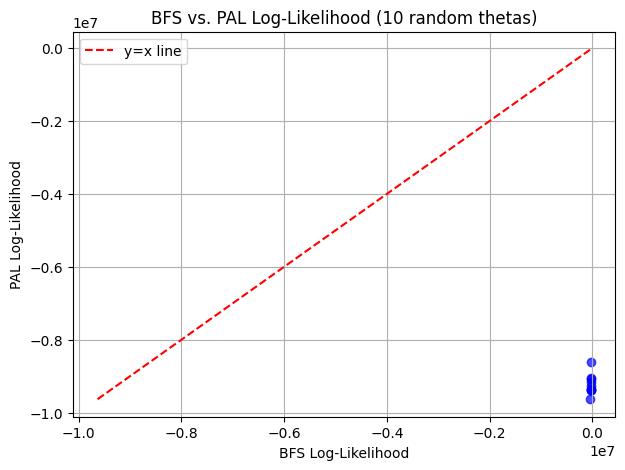

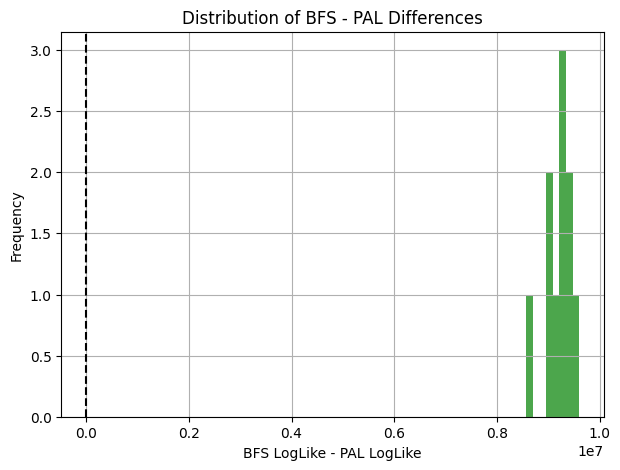

In [8]:
# Suppose we sample 10 different thetas from the same prior or from a chain:
n_compare = 10
Theta_list = []
for _ in range(n_compare):
    t_ = np.concatenate((
        np.random.gamma(5, 1, 16),
        get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)
    ))
    Theta_list.append(t_)

loglike_bfs_vals = []
loglike_pal_vals = []

for i, th in enumerate(Theta_list):
    lb = BFS_loglike(Y, th, Nx=Nx, R=19, ESS_min=999)
    lp = PAL_loglike(Y, th, R=19)
    loglike_bfs_vals.append(lb)
    loglike_pal_vals.append(lp)
    print(f"Theta #{i+1}: BFS={lb:.2f}, PAL={lp:.2f}, diff={lb-lp:.2f}")

loglike_bfs_vals = np.array(loglike_bfs_vals)
loglike_pal_vals = np.array(loglike_pal_vals)
diff_vals = loglike_bfs_vals - loglike_pal_vals

plt.figure(figsize=(7,5))
plt.scatter(loglike_bfs_vals, loglike_pal_vals, c='blue', alpha=0.7)
minval = min(loglike_bfs_vals.min(), loglike_pal_vals.min()) - 10
maxval = max(loglike_bfs_vals.max(), loglike_pal_vals.max()) + 10
plt.plot([minval, maxval], [minval, maxval], 'r--', label='y=x line')
plt.xlabel("BFS Log-Likelihood")
plt.ylabel("PAL Log-Likelihood")
plt.title("BFS vs. PAL Log-Likelihood (10 random thetas)")
plt.legend()
plt.grid(True)
plt.show()

# Histogram of differences
plt.figure(figsize=(7,5))
plt.hist(diff_vals, bins=8, alpha=0.7, color='green')
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel("BFS LogLike - PAL LogLike")
plt.ylabel("Frequency")
plt.title("Distribution of BFS - PAL Differences")
plt.grid(True)
plt.show()
